In [1]:
PATH = "/home/dude/Desktop/data/network_data/"

In [2]:
import numpy as np
import pandas as pd
import os

In [3]:
os.listdir(PATH)

['dataset_1.csv', 'dataset_3.csv', 'dataset_2.csv']

In [4]:
df = pd.DataFrame()
for file in os.listdir(PATH):
    temp_df = pd.read_csv(PATH + file)
    df = pd.concat([df, temp_df], axis=0)


In [5]:
df.drop("No.", axis=1, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30947 entries, 0 to 499
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Time           30947 non-null  float64
 1   Source         30947 non-null  object 
 2   Destination    30947 non-null  object 
 3   Protocol       30947 non-null  object 
 4   Length         30947 non-null  int64  
 5   Info           30947 non-null  object 
 6   Scr Port       27974 non-null  float64
 7   Dest Port      27974 non-null  float64
 8   Packet Length  30947 non-null  int64  
 9   Delta Time     30947 non-null  float64
dtypes: float64(4), int64(2), object(4)
memory usage: 2.6+ MB


In [7]:
df.head()

,Time,Source,Destination,Protocol,Length,Info,Scr Port,Dest Port,Packet Length,Delta Time
0,0.000000,108.217.33.201,108.217.32.1,ICMP,43,"Echo (ping) request id=0x4161, seq=26678/1392...",NaN,NaN,43,0.000000
1,0.001202,108.217.32.1,108.217.33.201,ICMP,60,"Echo (ping) reply id=0x4161, seq=26678/1392...",NaN,NaN,60,0.001202
2,0.049716,108.217.33.201,3.92.254.48,TCP,66,"45645 > 443 [RST, ACK] Seq=1 Ack=1 Win=501 L...",45645.0,443.0,66,0.048514
3,0.051266,108.217.33.201,9.9.9.9,DNS,90,Standard query 0x180d A rank.similarweb.com OPT,41739.0,53.0,90,0.001550
4,0.070091,108.217.33.201,23.23.189.93,UDP,487,65155 > 33434 Len=445,65155.0,33434.0,487,0.018825


## Feature Engineering/Data Cleaning

To fix missing port we will plug -1 for the port and make new feature that will check the protocol and if that protocol is a non-port using protocol then have a 1 else 0.

In [8]:
# Fill nan as -1
df[['Scr Port', 'Dest Port']] = df[['Scr Port', 'Dest Port']].fillna(-1.0)

In [9]:
df['Protocol'].unique()

array(['ICMP', 'TCP', 'DNS', 'UDP', 'TLSv1.2', 'ARP', 'STP', 'HTTP',
       'LLDP', 'TLSv1.3', 'MQTT', 'SSL', 'QUIC', 'ieee1905', 'NTP',
       'IGMPv3', 'CLASSIC-STUN', 'ICMPv6', 'MDNS', 'SSDP', 'DHCP', 'WSP'],
      dtype=object)

In [10]:
protocols_without_ports = ['ICMP', 'ARP', 'STP', 'IGMPv3', 'ICMPv6', 'ieee1905']

In [11]:
df['Protocol With Ports'] = df['Protocol'].apply(lambda x: 0 if x in protocols_without_ports else 1)

In [12]:
df.head()

,Time,Source,Destination,Protocol,Length,Info,Scr Port,Dest Port,Packet Length,Delta Time,Protocol With Ports
0,0.000000,108.217.33.201,108.217.32.1,ICMP,43,"Echo (ping) request id=0x4161, seq=26678/1392...",-1.0,-1.0,43,0.000000,0
1,0.001202,108.217.32.1,108.217.33.201,ICMP,60,"Echo (ping) reply id=0x4161, seq=26678/1392...",-1.0,-1.0,60,0.001202,0
2,0.049716,108.217.33.201,3.92.254.48,TCP,66,"45645 > 443 [RST, ACK] Seq=1 Ack=1 Win=501 L...",45645.0,443.0,66,0.048514,1
3,0.051266,108.217.33.201,9.9.9.9,DNS,90,Standard query 0x180d A rank.similarweb.com OPT,41739.0,53.0,90,0.001550,1
4,0.070091,108.217.33.201,23.23.189.93,UDP,487,65155 > 33434 Len=445,65155.0,33434.0,487,0.018825,1


For Packet Length, we will make categories based on the number of bytes

In [13]:
df['Packet Length'].describe(percentiles=[.25, .5, .6, .7, .75, 1])

count    30947.00000
mean       597.93686
std        624.05733
min         42.00000
25%         66.00000
50%         99.00000
60%        620.00000
70%       1292.00000
75%       1292.00000
100%      1514.00000
max       1514.00000
Name: Packet Length, dtype: float64

Categories will be:
- Small -> 0 to 74 bytes
- Medium -> 75 to 199 bytes
- Large -> 200 to 749 bytes
- Very Large -> 750 bytes and above 

In [14]:
def packet_size_class_selector(packet_size):
    """
    Function to put a packet into a class based on its size in bytes
    - Small -> 0 to 75 bytes
    - Medium -> 75 to 200 bytes
    - Large -> 200 to 750 bytes
    - Very Large -> 750 bytes< 

    Parameters:
    packet_size (int): Size of packet in bytes

    Returns:
    int: Class ID corresponding to the packet size.
    0 = Small
    1 = Medium 
    2 = Large
    3 = Very Large
    """
    if packet_size < 0:
        raise ValueError("Packet size must be a non-negative integer.")
    return (0 if packet_size <= 74 else 
            1 if packet_size <= 199 else 
            2 if packet_size <= 749 else 
            3)
 

In [15]:
df['Size Category'] = df['Packet Length'].apply(packet_size_class_selector)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30947 entries, 0 to 499
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Time                 30947 non-null  float64
 1   Source               30947 non-null  object 
 2   Destination          30947 non-null  object 
 3   Protocol             30947 non-null  object 
 4   Length               30947 non-null  int64  
 5   Info                 30947 non-null  object 
 6   Scr Port             30947 non-null  float64
 7   Dest Port            30947 non-null  float64
 8   Packet Length        30947 non-null  int64  
 9   Delta Time           30947 non-null  float64
 10  Protocol With Ports  30947 non-null  int64  
 11  Size Category        30947 non-null  int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 3.1+ MB


We will do label encoding to handle IP Adresses both source and destination.

In [17]:
from sklearn.preprocessing import LabelEncoder

source_encoder = LabelEncoder()
destination_encoder = LabelEncoder()

In [18]:
df['Destination Encoded'] = destination_encoder.fit_transform(df['Destination'])
df['Source Encoded'] = source_encoder.fit_transform(df['Source'])

In [19]:
df.drop(['Destination', 'Source'], axis=1, inplace=True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30947 entries, 0 to 499
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Time                 30947 non-null  float64
 1   Protocol             30947 non-null  object 
 2   Length               30947 non-null  int64  
 3   Info                 30947 non-null  object 
 4   Scr Port             30947 non-null  float64
 5   Dest Port            30947 non-null  float64
 6   Packet Length        30947 non-null  int64  
 7   Delta Time           30947 non-null  float64
 8   Protocol With Ports  30947 non-null  int64  
 9   Size Category        30947 non-null  int64  
 10  Destination Encoded  30947 non-null  int64  
 11  Source Encoded       30947 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 3.1+ MB


Use OneHotEncoder for the Protocol feature

In [31]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore')

In [45]:
encoded_protocols = one_hot_encoder.fit_transform(df['Protocol'].to_frame())
encoded_df = pd.DataFrame(encoded_protocols, columns=list(one_hot_encoder.categories_[0]))

In [47]:
df_reset = df.reset_index(drop=True)
encoded_df_reset = encoded_df.reset_index(drop=True)

# Concatenate the DataFrames
df = pd.concat([df_reset, encoded_df_reset], axis=1)

Now time to deal with the info feature

In [60]:
df['Info'].duplicated().value_counts()

Info
True     17314
False    13633
Name: count, dtype: int64

For now we will move on to the unsupervised learning analysis without the info feature. <br>
If we get to do an supervised learning tasks later, like classifing malicious packets, then we will try to vectorize it. 

In [64]:
df_no_info = df.drop('Info', axis=1)
# Drop protocol but keep it in original in case we need it later
df_no_info.drop('Protocol', axis=1, inplace=True)

## Clustering

We will use KMeans to try and find some clusters and try and derive a meaning for them

### KMeans Clustering

In [81]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

#### Find Optimal Number of Clusters

In [82]:
scaler = StandardScaler()
df_no_info_scaled = scaler.fit_transform(df_no_info)

In [105]:
kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(df_no_info_scaled)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

In [106]:
inertias

[990304.0000000003,
 875852.3185456496,
 806966.4455047959,
 764370.9744446727,
 738093.268131779,
 705889.6335287403,
 659298.6785823386,
 627059.2944987991,
 594783.8738324175]

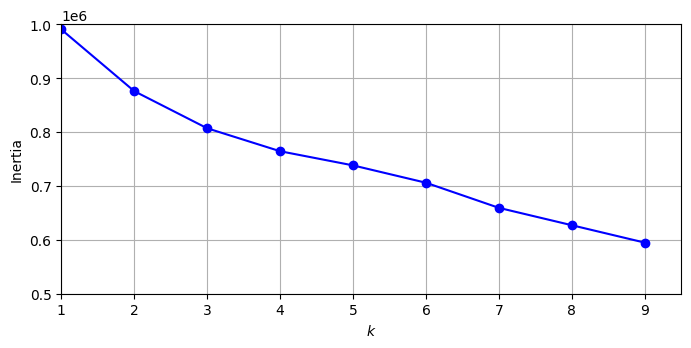

In [110]:
## Model Inertia vs K (number of clusters)

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.axis([1, 9.5, 500_000, 1_000_000])
plt.grid()
plt.show()

In [108]:
silhouette_scores = [silhouette_score(df_no_info_scaled, model.labels_)
                     for model in kmeans_per_k[1:]]

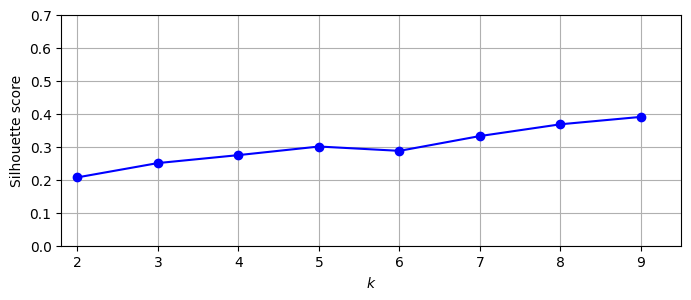

In [111]:
## Silhouette Score vs K (number of clusters)

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.axis([1.8, 9.5, 0, 0.7])
plt.grid()
plt.show()

Due to low scores we will try other methods before picking one

### DBSCAN

In [112]:
from sklearn.cluster import DBSCAN

In [130]:
dbscan = DBSCAN(eps=0.2, min_samples=5)
labels = dbscan.fit_predict(df_no_info_scaled)

In [141]:
## Get number of clusters
print(len(set(labels)))

538


In [142]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

In [144]:
print(davies_bouldin_score(df_no_info_scaled, labels))
print(calinski_harabasz_score(df_no_info_scaled, labels))

1.453845197732752
46.83783420944558
